In [1]:
import json
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Origin", "Faulty engine", "Size(Byte)", "Function Count"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    table_data.append([
        test_name,
        metadata['origin'],
        metadata['engine'],
        metadata['size'],
        metadata['function_count']
    ])

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")

# Save the table to a file
rq1_table_path = f'{evaluation.PAPER_PATH}/table/eval_set.tex'
with open(rq1_table_path, 'w') as file:
    file.write(latex_table)
    print(f"Table saved to {rq1_table_path}")

Table saved to /home/don/rr-reduce-paper/issta_2025/table/eval_set.tex


In [2]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Sort the metrics by key
metrics = dict(sorted(metrics.items()))

# Prepare the data for tabulation
table_data = []
headers = ["Name", "Target", "Success", "Size Reduced", "Split Time(ms)", "RR Time(ms)"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    target_function_count = len(data['rq1'])
    split_time = average([obj['split-time'] for obj in data['rq1'].values()])
    rr_time_values = [obj['rr-time'] for obj in data['rq1'].values() if obj['rr-time'] != 'fail']
    rr_time = average(rr_time_values) if rr_time_values else 'N/A'
    # rr_did_timeout = sum(1 for obj in data['rq1'].values() if obj['rr-did-timeout'] == True)
    rr_success = sum(1 for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail')
    rr_reduction_rate_values = [obj['sliced_file_size'] / metadata['size'] * 100 for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail']
    rr_reduction_rate = f"{average(rr_reduction_rate_values):.2f}%" if rr_reduction_rate_values else 'N/A'
    table_data.append([
        test_name,
        target_function_count,
        rr_success,
        rr_reduction_rate,
        split_time,
        rr_time,
    ])

# Calculate the sum of all the rows
total_target_function_count = sum(row[1] for row in table_data)
total_split_time = average([obj['split-time'] for data in metrics.values() for obj in data['rq1'].values()])
total_rr_time_values = [obj['rr-time'] for data in metrics.values() for obj in data['rq1'].values() if obj['rr-time'] != 'fail']
total_rr_time = average(total_rr_time_values) if total_rr_time_values else 'N/A'
# total_rr_did_timeout = sum(1 for data in metrics.values() for obj in data['rq1'].values() if obj['rr-did-timeout'] == True)
total_rr_success = sum(row[5] for row in table_data)
total_rr_reduction_rate_values = [obj['sliced_file_size'] / data['metadata']['size'] * 100 for data in metrics.values() for obj in data['rq1'].values() if obj['sliced_file_size'] != 'fail']
total_rr_reduction_rate = f"{average(total_rr_reduction_rate_values):.2f}%" if total_rr_reduction_rate_values else 'N/A'


# Where extracted is larger than
cases = []
for test_name, data in metrics.items():
    for fidx, obj in data['rq1'].items():
        if obj['sliced_file_size'] != 'fail' and obj['sliced_file_size'] > data['metadata']['size']:
            cases.append(f"{test_name}-{fidx}")

# Sort the cases
cases.sort()

# # Print the sorted cases
# for case in cases:
#     print(case)

print(f"Total number of cases where sliced_file_size is greater than metadata size: {len(cases)}")


# Append the total row to the table data
table_data.append([
    "Total",
    total_target_function_count,
    total_rr_success,
    total_rr_reduction_rate,
    total_split_time,
    total_rr_time,
])

# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")

# Add distinction for the total row
latex_table = latex_table.replace("Total", "\\hline\n\\textbf{Total}")

# Save the table to a file
rq1_table_path = f'{evaluation.PAPER_PATH}/table/rq1.tex'
with open(rq1_table_path, 'w') as file:
    file.write(latex_table)
    print(latex_table)
    print(f"Table saved to {rq1_table_path}")

Total number of cases where sliced_file_size is greater than metadata size: 59
\begin{tabular}{lrrlrr}
\hline
 Name          &   Target &   Success & Reduction Rate   &   Split Time(ms) &   RR Time(ms) \\
\hline
 boa           &     1000 &      1000 & 77.33\%           &        7109.98   &      20051.1  \\
 commanderkeen &     1000 &       985 & 8.95\%            &        4459.3    &      64414.3  \\
 funky-kart    &     1000 &      1000 & 48.27\%           &         949.176  &      73162.6  \\
 guiicons      &      505 &       505 & 33.87\%           &         439.646  &      15671.3  \\
 hydro         &     1000 &      1000 & 19.92\%           &         910.267  &       1849.31 \\
 jsc           &     1000 &       938 & 31.85\%           &        5412.93   &      14416.2  \\
 mandelbrot    &      167 &       167 & 49.62\%           &         136.922  &      40086.1  \\
 rfxgen        &      587 &       587 & 32.79\%           &         555.371  &      13282.7  \\
 rguilayout    &    

Split Time Regression Statistics:
Slope: 0.000348
Intercept: 456.498501
R-squared: 0.755024
P-value: 0.000000
Standard Error: 0.000045

RR Time Regression Statistics:
Slope: -0.000209
Intercept: 31137.605619
R-squared: 0.000968
P-value: 0.893505
Standard Error: 0.001538
Figure saved to /home/don/rr-reduce-paper/issta_2025/figures/rq1-size-time.pdf


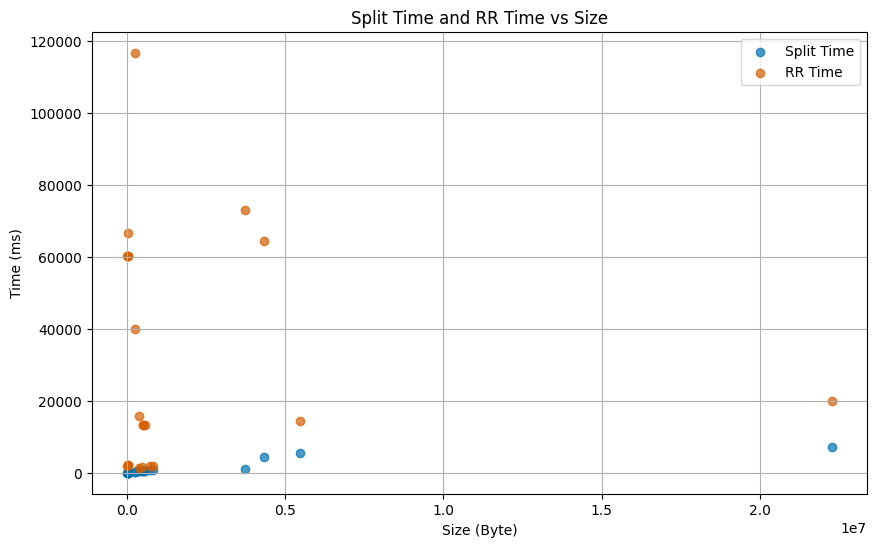

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

# Function to calculate average, ignoring 'fail' values
def average(lst):
    valid = [x for x in lst if x != 'fail']
    return sum(valid) / len(valid) if valid else 0

# Extract data for plotting
x_data = [data['metadata']['size'] for data in metrics.values()]
split_time_data = [average([obj['split-time'] for obj in data['rq1'].values()]) for data in metrics.values()]
rr_time_data = [average([obj['rr-time'] for obj in data['rq1'].values() if obj['rr-time'] != 'fail']) for data in metrics.values()]

# Convert to numpy arrays
x = np.array(x_data)
y_split = np.array(split_time_data)
y_rr = np.array(rr_time_data)

# Calculate linear regression statistics
slope_split, intercept_split, r_value_split, p_value_split, std_err_split = stats.linregress(x, y_split)
slope_rr, intercept_rr, r_value_rr, p_value_rr, std_err_rr = stats.linregress(x, y_rr)

# Print regression statistics
print("Split Time Regression Statistics:")
print(f"Slope: {slope_split:.6f}")
print(f"Intercept: {intercept_split:.6f}")
print(f"R-squared: {r_value_split**2:.6f}")
print(f"P-value: {p_value_split:.6f}")
print(f"Standard Error: {std_err_split:.6f}")
print()

print("RR Time Regression Statistics:")
print(f"Slope: {slope_rr:.6f}")
print(f"Intercept: {intercept_rr:.6f}")
print(f"R-squared: {r_value_rr**2:.6f}")
print(f"P-value: {p_value_rr:.6f}")
print(f"Standard Error: {std_err_rr:.6f}")

# Plot the data (unchanged from your original code)

color_split = '#0072B2'  # Blue
color_rr = '#D55E00'  # Vermilion
plt.figure(figsize=(10, 6))
plt.scatter(x_data, split_time_data, alpha=0.7, label='Split Time', color=color_split)
plt.scatter(x_data, rr_time_data, alpha=0.7, label='RR Time', color=color_rr)
plt.xlabel('Size (Byte)')
plt.ylabel('Time (ms)')
plt.title('Split Time and RR Time vs Size')
plt.legend()
plt.grid(True)

# Save the figures to a file
fig_path_pdf = f'{evaluation.PAPER_PATH}/figures/rq1-size-time.pdf'
plt.savefig(fig_path_pdf)
print(f"Figure saved to {fig_path_pdf}")

In [4]:
import json
from numpy import average
import tabulate
import evaluation

# Load the JSON data
with open("metrics.json", "r") as f:
    metrics = json.load(f)

# Prepare the data for tabulation
table_data = []
headers = ["Original Size", "RR-Reduce Size",  "RR-Reduce Time", "wasm-reduce Size", "wasm-reduce Time", "wasm-shrink Size", "wasm-shrink Time"]

for test_name, data in metrics.items():
    metadata = data['metadata']
    original_size = metadata['size']
    rr_reduce_size = -1
    rr_reduce_time = -1
    wasm_reduce_size = -1
    wasm_reduce_time = -1
    wasm_shrink_size = -1
    wasm_shrink_time = -1
    table_data.append([
        test_name,
        original_size,
        rr_reduce_size,
        rr_reduce_time,
        wasm_reduce_size,
        wasm_reduce_time,
        wasm_shrink_size,
        wasm_shrink_time
    ])
# Generate the LaTeX table
latex_table = tabulate.tabulate(table_data, headers, tablefmt="latex_raw")

# Modify the LaTeX table string
latex_table = latex_table.replace("#", "\\#")
latex_table = latex_table.replace("%", "\\%")

# Save the table to a file
rq2_table_path = f'{evaluation.PAPER_PATH}/table/rq2.tex'
with open(rq2_table_path, 'w') as file:
    file.write(latex_table)
    print(f"Table saved to {rq2_table_path}")

Table saved to /home/don/rr-reduce-paper/issta_2025/table/rq2.tex
